In [18]:
using QuantumCollocation
using NamedTrajectories
using Revise
using LinearAlgebra
using CairoMakie
using MakieTeX

In [2]:
traj_path = "../../examples/scripts/trajectories/three_qubits/swap_gate/continuation/T_50_Q_200.0_iter_200_fidelity_0.9999813247231153_00000.jld2"
traj = load_traj(traj_path)

NamedTrajectory([1.0 0.9964216900793339 … 0.9979538220533506 0.9999713246532868; 0.0 0.001403049409548593 … 0.013690714288806664 0.0001883125142660733; … ; 0.0 0.0 … -0.05766202778191268 -0.021557802878392335; 0.0 0.0 … 0.032903267631053265 0.02017221475009702], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0  …  -0.04021357541797059, -0.798930972504384, 0.0038358844773824343, -0.001867746074498528, -0.008390786732032033, 0.014144664772166885, -0.012666684373027568, -0.001240671829320722, -0.021557802878392335, 0.02017221475009702], 50, 4.0, true, 283, (controls = 127, ddu = 6, states = 156, G⃗ = 120, Ũ⃗ = 128, ψ̃ = 16, u = 6, du = 6, Δt = 1), (ddu = ([-0.001, -0.001, -0.001, -0.001, -0.001, -0.001], [0.001, 0.001, 0.001, 0.001, 0.001, 0.001]), u = ([-0.25132741228718347, -0.25132741228718347, -0.25132741228718347, -0.25132741228718347, -0.25132741228718347, -0.25132741228718347], [0.25132741228718347, 0.25132741228718347, 0.25132741228718347, 0.25132741228718347, 0.25132741228718347

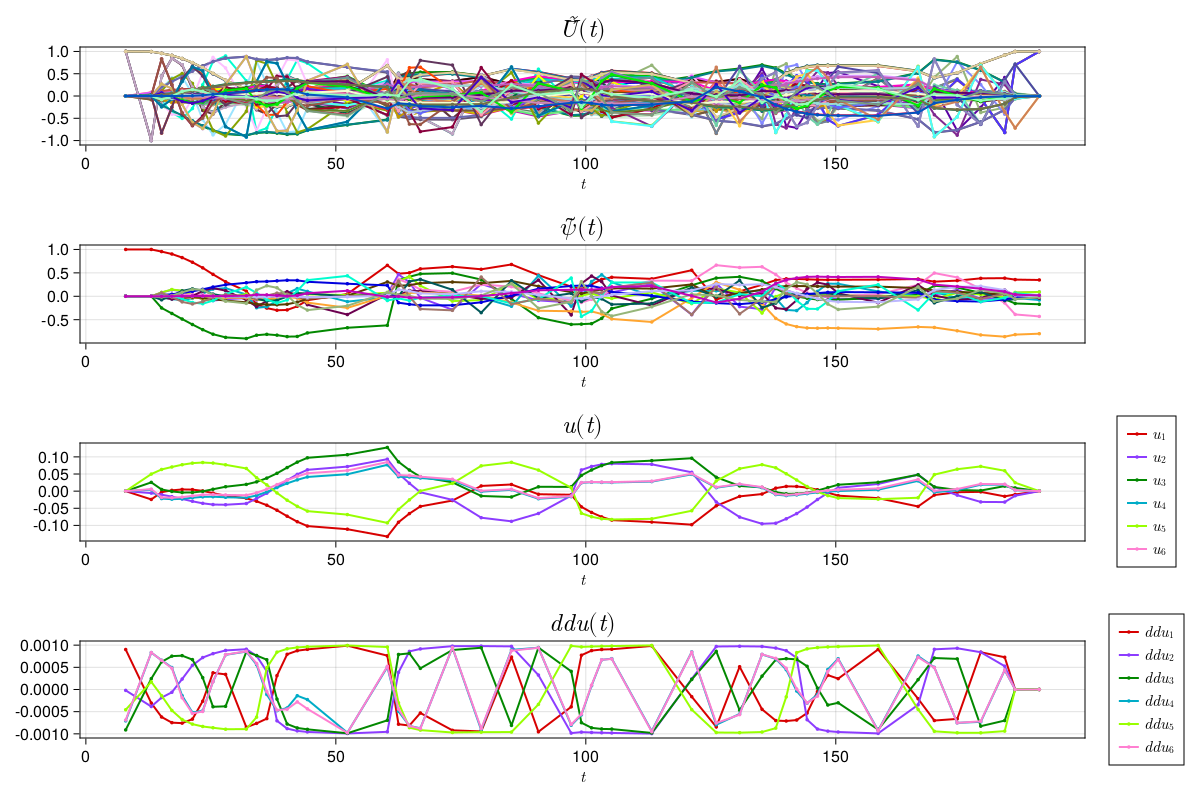

In [3]:
plot(traj, [:Ũ⃗, :ψ̃, :u, :ddu]; ignored_labels=[:Ũ⃗, :ψ̃], timestep_name=:Δt)

In [5]:
e0 = [1, 0]
e1 = [0, 1]

Id = GATES[:I]

e00 = e0 * e0'
e11 = e1 * e1'
e01 = e0 * e1'
e10 = e1 * e0'

U_goal_analytic =
    e00 ⊗ Id ⊗ e00 +
    e10 ⊗ Id ⊗ e01 +
    e01 ⊗ Id ⊗ e10 +
    e11 ⊗ Id ⊗ e11

U_goal = Matrix{ComplexF64}(U_goal_analytic)



8×8 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  1.0+0.0im

In [7]:
a_dag = create(2)
a = annihilate(2)

ωs = 2π * [5.18, 5.12, 5.06]
ω_d = 2π * 5.12

ξs = 2π * fill(0.340, 3) # ξ = 0.340 GHz

J_12 = 5.0e-3
J_23 = 5.0e-3


function lift(U, q, n; l=2)
    Is = Matrix{Number}[I(l) for i in 1:n]
    Is[q] = U
    return foldr(kron, Is)
end

lift(number(2), 1, 3)
lift(a_dag, 1, 3)
lift(a, 1, 3)

H_drift = sum(
    (ωs[q] - ω_d) * lift(a_dag, q, 3) * lift(a, q, 3) -
    ξs[q] / 2 * lift(a_dag, q, 3) * lift(a_dag, q, 3) * lift(a, q, 3) * lift(a, q, 3)
        for q = 1:3
)

# dispersive coupling
H_drift +=
    J_12 * (
        lift(a_dag, 1, 3) * lift(a, 2, 3) +
        lift(a, 1, 3) * lift(a_dag, 2, 3)
    ) +
    J_23 * (
        lift(a_dag, 2, 3) * lift(a, 3, 3) +
        lift(a, 2, 3) * lift(a_dag, 3, 3)
    )

H_drives_Re = [lift(a, j, 3) + lift(a_dag, j, 3) for j = 1:3]
H_drives_Im = [1im * (lift(a, j, 3) - lift(a_dag, j, 3)) for j = 1:3]

H_drives = vcat(H_drives_Re, H_drives_Im)
n_drives = length(H_drives)

system = QuantumSystem(H_drift, H_drives)



QuantumSystem([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.0 … 0.0 0.0; -1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … -1.0 0.0]], Dict{Symbol, Any}())

In [8]:
# |0⟩ rollout test
ψ = qubit_system_state("000")
ψ̃ = ket_to_iso(ψ)
ψ̃_goal = ket_to_iso(U_goal * ψ)
Ψ̃ = rollout(ψ̃, traj.u, traj.Δt, system)
println("|0⟩ Rollout fidelity:   ", fidelity(Ψ̃[:, end], ψ̃_goal))



|0⟩ Rollout fidelity:   0.12136316479615704


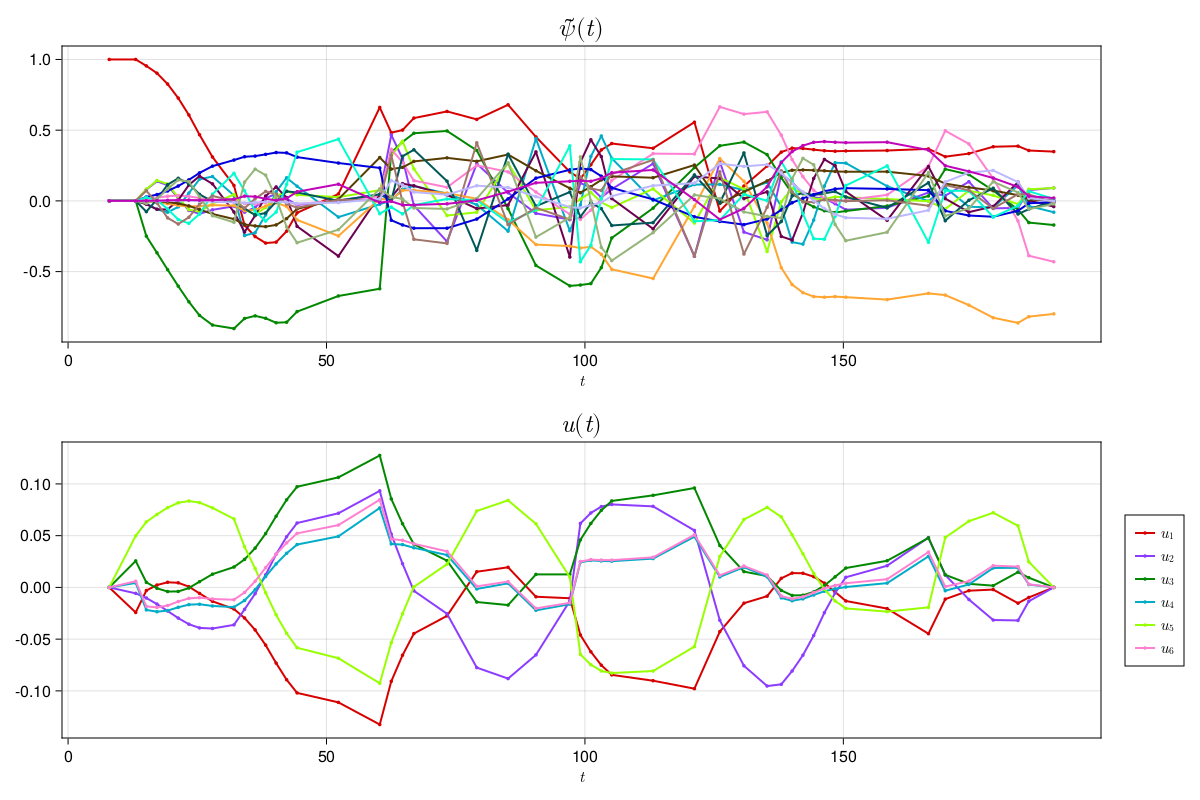

In [9]:
fig = plot(traj, [:ψ̃, :u]; ignored_labels=:ψ̃, timestep_name=:Δt)

In [41]:
MakieTeX.CURRENT_TEX_ENGINE[] = `lualatex`

`lualatex`

In [48]:
ftex = Figure()
l1 = LTeX(ftex[1,1], L"\psi (t)", tellwidth=false, tellheight=true)
ax = Axis(ftex[2,1])
# series!(ax, get_times(traj, :Δt), traj.ψ̃, color=:picasso)
series!(ax, 10, randn(3,10), color=:picasso)
plot_name = "test.pdf"
save(plot_name, ftex)

MethodError: MethodError: no method matching page2img(::Vector{CachedTeX}, ::Int64; render_density=1.0f0)
Closest candidates are:
  page2img(!Matched::CachedTeX, ::Int64; scale, render_density) at ~/.julia/packages/MakieTeX/larXD/src/rendering.jl:147